In [1]:

%matplotlib inline
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df

In [34]:
총df

,영업일,인덱스,상승예측확률,실제수익률
0,41~60일 차,US500,[1.0],-0.017987
0,[21.]~[40.]일 차,US500,[1.0],-0.005205
0,[21.]~[40.]일 차,US500,[1.0],0.013502
0,[21.]~[40.]일 차,US500,[1.0],0.048796
0,[21.]~[40.]일 차,US500,[1.0],0.054401
0,[21.]~[40.]일 차,US500,[1.0],0.002989
0,[21.]~[40.]일 차,US500,[1.0],0.038507
0,[21.]~[40.]일 차,US500,[1.0],0.028085
0,[21.]~[40.]일 차,US500,[1.0],0.000650
0,[21.]~[40.]일 차,US500,[1.0],0.015148


In [89]:
KS11 = fdr.DataReader("KS11","2010-01-01","2019-01-01")
KQ11= fdr.DataReader("KQ11","2010-01-01","2019-01-01")
US500 = fdr.DataReader("US500","2010-01-01","2019-01-01")
HSI = fdr.DataReader("HSI","2010-01-01","2019-01-01")
IXIC = fdr.DataReader("IXIC","2010-01-01","2019-01-01")

KeyboardInterrupt: 

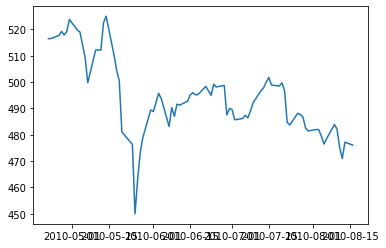

In [59]:
plt.plot(df_before["Close"][:100][:-20])

In [74]:
a=pd.DataFrame(df_before["Close"][:100])

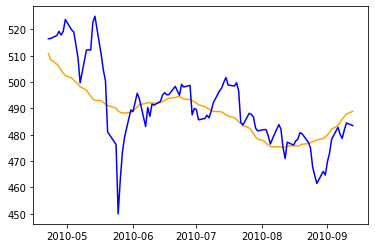

In [93]:
a=y_before[20:120]
b=df_before["Close"][:100]
a.index=b.index
plt.plot(a,'orange')

plt.plot(b,'b')

In [49]:
import time
start = time.time()
Xtrain_size=0
예측dic={}
수익률dic={}
END=0
초기돈=10000
d=1
dd=20
BATCH = 20
투자결과=[]
총df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])


  
for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["KS11","KQ11","IXIC","HSI","US500"]):


    df = 인덱스
    df=get_MA(df)
    df=get_stochastic(df)
    df=df[0:-(len(df)%BATCH)]
    #-----------------------------------------------
    
    # 값과 이평선 비교하기 ----------------
    MA_26=df["Close"].rolling(26).mean()
    y_before=MA_26.dropna()
    df_before=df[25:] #값과 값 -> [:] 값과 이평선 ->[25:] [25:0] xx 
    
    #y=np.where(np.array(df_before["Close"].shift(-1).dropna()) > np.array(y_before.shift(-1).dropna()),1,0) #값과 이평선 (1일 차)
    #y=np.where(df["Change"].shift(-1).dropna()>0,1,0) #값과 값 ( 1일 차 )
    #y=np.where(np.array(df_before["Close"][:-20].shift(-1).dropna()) > np.array(y_before[20:].shift(-1).dropna()),1,0) #값과 이평선 ( 20일 차 )
    #y=np.where(df["Change"][20:].shift(-1).dropna() > 0,1,0) #값과 값 ( 20일 차 )
    
    df = df_before[20:-1].values #1일차면 [:-1], 20일차면 [20:-1] 
    df.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)
    X=df

    setlen=int(len(X)/20*0.7)*20

    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]

    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 11)))
    for i in range(3):
        model.add(Dense(36,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.fit(X_train, y_train, epochs=3, batch_size=16,validation_split=0.1,verbose=0)
    pred=np.where(model.predict(X_test)>0.5,1,0)
    
    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
    예측dic[인덱스명]=pred
    수익률dic[인덱스명]=dfA["Close"][setlen:]

    #예측머신 끝 --------predict -> 12근방 나옴 ---------------------


        
        
버튼=1
date=0

while 버튼==1:#예측머신돌리기
    day= str(d+(20*date)) +"~" + str(dd+(20*date)) + "일 차"
    date=date+1
    print(day,"---------------------------------")

    세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
    
    for x,y in zip(예측dic.keys(),예측dic.values()):
          
           #종료 조건
        if(len(수익률dic[x])==BATCH+20):
            버튼=0
            print("종료")
            break
        
    
        pred=y[BATCH-20:BATCH]
        예측 = (sum(pred))/20
        실제수익률 = ((수익률dic[x][BATCH+20])/(수익률dic[x][BATCH]))-1
        턴df=pd.DataFrame(data={"영업일":[day],"인덱스":[x],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
        세트df=pd.concat([세트df,턴df])    
    
    if 버튼==0:
        break
        
        
    earn_list=[]             
    for x,y in zip(세트df["상승예측확률"],세트df["실제수익률"]):
        
        if x>=0.6:
            earn_list.append(y)

    earn_list2=[]
    if len(earn_list)!=0:
        초기돈=초기돈/(len(earn_list))
        for y in earn_list:
            earn_list2.append(초기돈+(초기돈*y))
        초기돈=sum(earn_list2)    
    else:
        earn_list2.append(초기돈)


    총df=pd.concat([총df,세트df])
    BATCH=BATCH+20

    print("분산 투자 : ",earn_list2)
    print("투자 결과 : ",초기돈)
    print("\n★")
    print(세트df)
    print("★\n")
    
   
            #MONEY = 투잣돈 * A의 20일후 change + 투잣돈 * B의 20일후 change #"20일차MONEY"출력


KS11 정확도 :  0.6299694189602446


KeyboardInterrupt: 

In [14]:
# 면역전략의 수익
list=[]
for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["KS11","KQ11","IXIC","HSI","US500"]):
    돈 = 10000
    df=인덱스
    
    df=df[25:]
    df=df[len(df)%20:]
    setlen=int(len(X)/20*0.7)*20
    df=df[setlen:]
    
    print(인덱스명," : " , 돈 + ( 돈 * (df["Close"][-1] - df["Close"][0])/ df["Close"][0] ))
    print("수익률 : ",((df["Close"][-1] - df["Close"][0])/ df["Close"][0] ) *100 , "%\n")
    list.append((df["Close"][-1] - df["Close"][0])/ df["Close"][0] )
    
print("분산 투자시")
list2=[]
for x in list:
    print(2000+(2000*x))
    list2.append(2000+(2000*x))
print("\n총 수익 : ",sum(list2))

KS11  :  10662.515280375295
수익률 :  6.625152803752961 %

KQ11  :  10519.064003362862
수익률 :  5.190640033628627 %

IXIC  :  14684.728747878162
수익률 :  46.84728747878163 %

HSI  :  13317.40475054438
수익률 :  33.174047505443795 %

US500  :  13355.051462910478
수익률 :  33.550514629104775 %

분산 투자시
2132.5030560750592
2103.8128006725724
2936.9457495756324
2663.4809501088757
2671.0102925820956

총 수익 :  12507.752849014234


In [45]:
X_train = np.reshape(X_train, (int(X_train.shape[0]/BATCH),BATCH, X_train.shape[1]))[:,:19,:]

ValueError: cannot reshape array of size 20880 into shape (4,20,20)

In [19]:
y_train.shape

(84, 1)

SyntaxError: can't assign to function call (<ipython-input-39-0b6f1e348eaf>, line 2)